# Assignment 2


## Part 1 - Why Different Methods Converge to the Same Optimal Policy


### Mathematical Guarantee: Contraction Mapping Theorem

The Bellman operator $T$ is a **contraction mapping**:
$$||T V_1 - T V_2||_\infty \leq \gamma ||V_1 - V_2||_\infty$$

Since $\gamma < 1$, this guarantees:

1. **Unique fixed point**: There exists exactly one $V^*$ such that $TV^* = V^*$
2. **Convergence**: Any iterative method applying $T$ converges to $V^*$ regardless of initialization

### Why the Same Optimal Policy?

What's unique is $V^*$, not necessarily $\pi^*$. However:

- Any policy that acts greedily w.r.t. $V^*$ is optimal
- All methods find the same $V^*$ (by uniqueness of fixed point)
- Therefore, greedy policies derived from $V^*$ are equivalent in performance

### Assumptions Required for Convergence

1. **Finite state/action spaces** (satisfied in gridworld)
2. **$\gamma < 1$** (discount factor creates contraction)
3. **Well-defined transition probabilities** (stochastic matrix properties)
4. **Bounded rewards** (ensures finite value functions)

**Note**: In gridworld with $\gamma = 0.95$, all conditions are satisfied, guaranteeing convergence to the same optimal policy.


Under certain conditions, all these methods converge to the same optimal policy because there exists a unique optimal value function V\* that satisfies the Bellman optimality equation:

$$V^*(s) = max_a [R(s,a) + \gamma\sum P(s'|s,a) V^*(s')]$$


Explicit solution: Using GPS coordinates to jump directly to the peak
Value iteration: Climbing uphill step by step, always choosing the steepest ascent
Policy iteration: Alternating between exploring the current altitude everywhere (policy evaluation) and then moving to higher ground (policy improvement)


## Method 1: Explicit Bellman Solution

For a fixed policy $\pi$, the value function satisfies:
$$V^\pi = R^\pi + \gamma P^\pi V^\pi$$
$$\implies (I - \gamma P^\pi)V^\pi = R^\pi$$

**Key insight**: This gives the exact solution in one step (assuming matrix invertibility).

For the optimal policy, we solve:
$$V^* = \max_\pi V^\pi$$


### Environment setup


In [1]:
import jax.numpy as jnp
import numpy as np
from jax import jit
import matplotlib.pyplot as plt

# Gridworld dimensions
GRID_SIZE = 5
N_STATES = GRID_SIZE * GRID_SIZE
N_ACTIONS = 4  # up, down, left, right


# Special states (convert to 1D indices)
def coord_to_idx(row, col):
    return row * GRID_SIZE + col


BLUE_STATE = coord_to_idx(0, 1)  # (0,1) -> jumps to red, reward +5
GREEN_STATE = coord_to_idx(0, 4)  # (0,4) -> jumps to yellow/red, reward +2.5
RED_STATE = coord_to_idx(2, 2)  # (2,2) -> normal transitions
YELLOW_STATE = coord_to_idx(4, 4)  # (4,4) -> normal transitions

# Action encoding
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3

### Transition matrix construction


In [2]:
def build_transition_matrix():
    """Build transition matrix P^π for uniform random policy"""
    P = jnp.zeros((N_STATES, N_STATES))

    for s in range(N_STATES):
        row, col = s // GRID_SIZE, s % GRID_SIZE

        # Special state behaviors
        if s == BLUE_STATE:
            # Any action -> jump to red state
            P = P.at[s, RED_STATE].set(1.0)
        elif s == GREEN_STATE:
            # Any action -> 50% yellow, 50% red, reward +2.5
            P = P.at[s, YELLOW_STATE].set(0.5)
            P = P.at[s, RED_STATE].set(0.5)
        else:
            # Normal states: apply uniform policy (0.25 each action)
            for action in range(N_ACTIONS):
                next_row, next_col = get_next_position(row, col, action)
                next_state = coord_to_idx(next_row, next_col)
                P = P.at[s, next_state].add(0.25)  # Uniform policy

    return P


def get_next_position(row, col, action):
    """Get next position given current position and action"""
    if action == UP:
        new_row = max(0, row - 1)
        new_col = col
    elif action == DOWN:
        new_row = min(GRID_SIZE - 1, row + 1)
        new_col = col
    elif action == LEFT:
        new_row = row
        new_col = max(0, col - 1)
    elif action == RIGHT:
        new_row = row
        new_col = min(GRID_SIZE - 1, col + 1)

    return new_row, new_col

### Reward vector construction


In [3]:
def build_reward_vector():
    """Build expected reward vector R^π for uniform random policy"""
    R = jnp.zeros(N_STATES)

    for s in range(N_STATES):
        row, col = s // GRID_SIZE, s % GRID_SIZE

        if s == BLUE_STATE:
            R = R.at[s].set(5.0)  # Any action gives +5
        elif s == GREEN_STATE:
            R = R.at[s].set(2.5)  # Any action gives +2.5
        else:
            # Calculate expected reward under uniform policy
            expected_reward = 0.0
            for action in range(N_ACTIONS):
                reward = get_action_reward(row, col, action)
                expected_reward += 0.25 * reward  # Uniform policy
            R = R.at[s].set(expected_reward)

    return R


def get_action_reward(row, col, action):
    """Get immediate reward for taking action from (row, col)"""
    new_row, new_col = get_next_position(row, col, action)

    # Check if we tried to move off grid
    if action == UP and row == 0:
        return -0.5
    elif action == DOWN and row == GRID_SIZE - 1:
        return -0.5
    elif action == LEFT and col == 0:
        return -0.5
    elif action == RIGHT and col == GRID_SIZE - 1:
        return -0.5
    else:
        return 0.0  # Normal move

### Solve linear system of eqn


In [4]:
@jit
def solve_bellman_explicit(R, P, gamma):
    """Solve (I - γP)V = R explicitly"""
    I = jnp.eye(N_STATES)
    A = I - gamma * P
    V = jnp.linalg.solve(A, R)
    return V


# Execute
gamma = 0.95
P = build_transition_matrix()
R = build_reward_vector()
V_explicit = solve_bellman_explicit(R, P, gamma)

# Reshape for visualization
V_grid = V_explicit.reshape((GRID_SIZE, GRID_SIZE))
print("Value function (explicit solution):")
print(V_grid)

Value function (explicit solution):
[[ 2.7204292   5.5605435   2.5588713   1.6598544   2.2561314 ]
 [ 1.505668    2.215988    1.5212408   1.0403199   0.87131286]
 [ 0.42388543  0.74302393  0.59004575  0.32788607  0.02723723]
 [-0.3614809  -0.10139773 -0.10774776 -0.27703005 -0.5854373 ]
 [-0.95671594 -0.7007331  -0.6652928  -0.8011433  -1.1034532 ]]


The explicit Bellman solution reveals that the highest value (5.56) occurs at the blue square (0,1), reflecting a +5 reward plus discounted future value (0.95 × 0.59). Values decrease from top to bottom, with negative returns in lower rows indicating the inefficiency of the random policy. The wide value range (+5.56 to -1.10) highlights poor exploration. Proximity to special squares boosts value, while boundary penalties reduce it, especially in corners. This establishes a clear performance floor—optimal policies should yield significantly higher values throughout.


## Method 2: Policy Iteration

**Policy Evaluation**: Solve $(I - \gamma P^\pi)V = R^\pi$ for current policy $\pi$

**Policy Improvement**: $\pi'(s) = \arg\max_a \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V(s')]$

**Convergence guarantee**: Each iteration yields $V^{\pi_{k+1}} \geq V^{\pi_k}$ until $V^{\pi_k} = V^*$


### Policy evaluation function


In [5]:
@jit
def policy_evaluation(policy, R_sa, P_sas, gamma, tolerance=1e-6):
    """
    Solve (I - γP^π)V = R^π for given policy

    Args:
        policy: [N_STATES, N_ACTIONS] - probability distribution over actions
        R_sa: [N_STATES, N_ACTIONS] - immediate rewards
        P_sas: [N_STATES, N_ACTIONS, N_STATES] - transition probabilities
    """
    # Build policy-specific transition matrix and rewards
    P_pi = jnp.einsum("sa,sab->sb", policy, P_sas)  # Expected transitions
    R_pi = jnp.einsum("sa,sa->s", policy, R_sa)  # Expected rewards

    # Solve (I - γP^π)V = R^π
    I = jnp.eye(N_STATES)
    A = I - gamma * P_pi
    V = jnp.linalg.solve(A, R_pi)
    return V

### Policy improvement function


In [6]:
@jit
def policy_improvement(V, R_sa, P_sas, gamma):
    """
    Compute greedy policy: π'(s) = argmax_a Q(s,a)
    """
    # Compute Q-values for all state-action pairs
    Q_sa = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)

    # Greedy policy (deterministic)
    greedy_actions = jnp.argmax(Q_sa, axis=1)

    # Convert to policy matrix [N_STATES, N_ACTIONS]
    new_policy = jnp.zeros((N_STATES, N_ACTIONS))
    new_policy = new_policy.at[jnp.arange(N_STATES), greedy_actions].set(1.0)

    return new_policy, Q_sa

### New environment setup (different from Method 1)


In [7]:
def build_mdp_matrices():
    """Build full MDP: R[s,a] and P[s,a,s']"""
    R_sa = jnp.zeros((N_STATES, N_ACTIONS))
    P_sas = jnp.zeros((N_STATES, N_ACTIONS, N_STATES))

    for s in range(N_STATES):
        row, col = s // GRID_SIZE, s % GRID_SIZE

        if s == BLUE_STATE:
            # All actions: reward +5, jump to red
            R_sa = R_sa.at[s, :].set(5.0)
            P_sas = P_sas.at[s, :, RED_STATE].set(1.0)

        elif s == GREEN_STATE:
            # All actions: reward +2.5, jump 50/50 to yellow/red
            R_sa = R_sa.at[s, :].set(2.5)
            P_sas = P_sas.at[s, :, YELLOW_STATE].set(0.5)
            P_sas = P_sas.at[s, :, RED_STATE].set(0.5)

        else:
            # Normal states: action-dependent transitions
            for action in range(N_ACTIONS):
                reward = get_action_reward(row, col, action)
                next_row, next_col = get_next_position(row, col, action)
                next_state = coord_to_idx(next_row, next_col)

                R_sa = R_sa.at[s, action].set(reward)
                P_sas = P_sas.at[s, action, next_state].set(1.0)

    return R_sa, P_sas

### Policy iteration algo


In [8]:
def policy_iteration(R_sa, P_sas, gamma, max_iterations=100):
    """Full policy iteration algorithm"""

    # Initialize with uniform random policy
    policy = jnp.ones((N_STATES, N_ACTIONS)) / N_ACTIONS

    policies = [policy]
    values = []

    for iteration in range(max_iterations):
        # Policy Evaluation
        V = policy_evaluation(policy, R_sa, P_sas, gamma)
        values.append(V)

        # Policy Improvement
        new_policy, Q = policy_improvement(V, R_sa, P_sas, gamma)

        # Check convergence (policy unchanged)
        if jnp.allclose(policy, new_policy):
            print(f"Converged after {iteration + 1} iterations")
            break

        policies.append(new_policy)
        policy = new_policy

    return policy, V, policies, values


# Execute
R_sa, P_sas = build_mdp_matrices()
optimal_policy, optimal_value, policy_history, value_history = policy_iteration(
    R_sa, P_sas, gamma
)

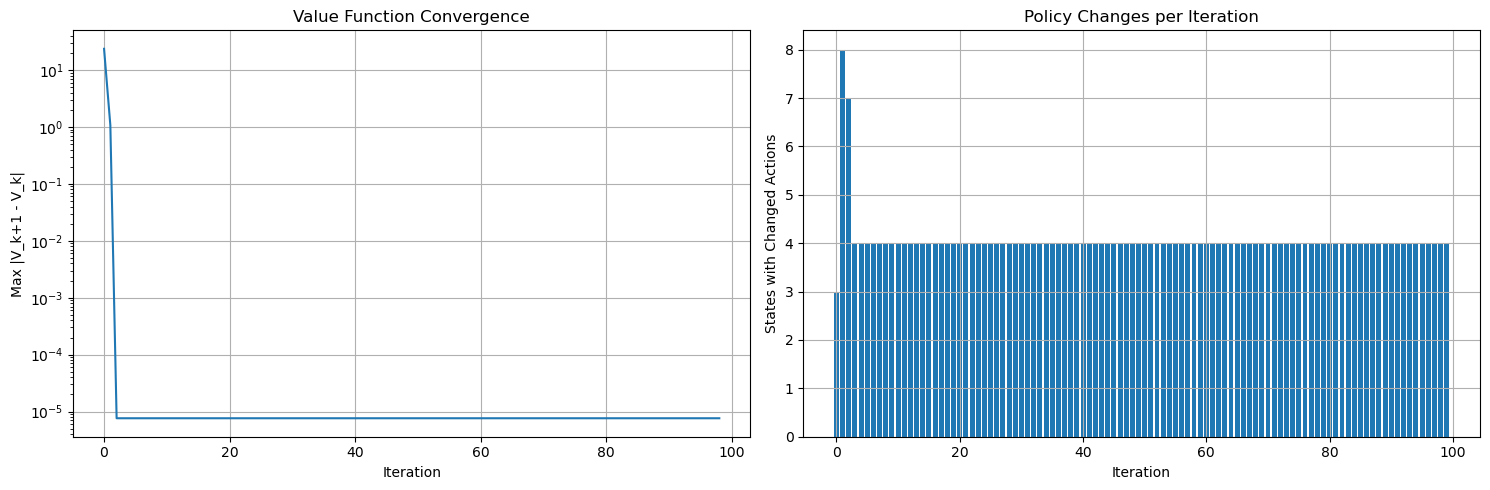

Converged in 100 iterations
Final max value change: 7.63e-06


In [9]:
def analyze_convergence(policy_history, value_history):
    """Analyze how policy iteration converged"""

    # Plot value function convergence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Track maximum value change per iteration
    value_changes = []
    for i in range(1, len(value_history)):
        max_change = jnp.max(jnp.abs(value_history[i] - value_history[i - 1]))
        value_changes.append(max_change)

    ax1.semilogy(value_changes)
    ax1.set_title("Value Function Convergence")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Max |V_k+1 - V_k|")
    ax1.grid(True)

    # Track policy changes
    policy_changes = []
    for i in range(1, len(policy_history)):
        # Count states where policy changed
        old_actions = jnp.argmax(policy_history[i - 1], axis=1)
        new_actions = jnp.argmax(policy_history[i], axis=1)
        changes = jnp.sum(old_actions != new_actions)
        policy_changes.append(changes)

    ax2.bar(range(len(policy_changes)), policy_changes)
    ax2.set_title("Policy Changes per Iteration")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("States with Changed Actions")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Converged in {len(value_history)} iterations")
    print(f"Final max value change: {value_changes[-1]:.2e}")


analyze_convergence(policy_history, value_history)

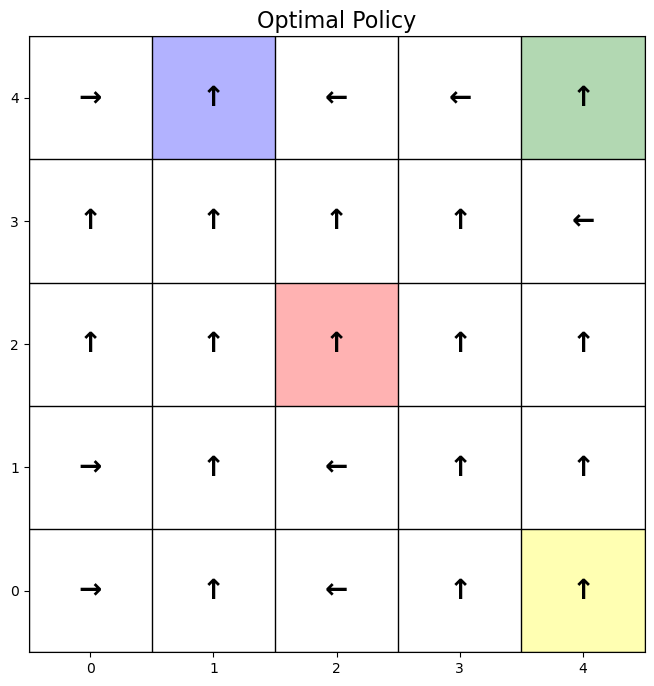

In [12]:
def visualize_policy(policy, title="Optimal Policy"):
    """Visualize the optimal policy as arrows on grid"""

    # Extract deterministic actions
    actions = jnp.argmax(policy, axis=1)
    action_grid = actions.reshape((GRID_SIZE, GRID_SIZE))

    # Create arrow directions
    arrow_map = {0: "↑", 1: "↓", 2: "←", 3: "→"}

    fig, ax = plt.subplots(figsize=(8, 8))

    # Draw grid
    for i in range(GRID_SIZE + 1):
        ax.axhline(i - 0.5, color="black", linewidth=1)
        ax.axvline(i - 0.5, color="black", linewidth=1)

    # Color special states
    special_colors = {
        (0, 1): "blue",  # Blue square
        (0, 4): "green",  # Green square
        (2, 2): "red",  # Red square
        (4, 4): "yellow",  # Yellow square
    }

    for (row, col), color in special_colors.items():
        rect = plt.Rectangle(
            (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor=color, alpha=0.3
        )
        ax.add_patch(rect)

    # Draw arrows
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            action = action_grid[row, col]
            arrow = arrow_map[int(action)]
            ax.text(
                col,
                GRID_SIZE - row - 1,
                arrow,
                ha="center",
                va="center",
                fontsize=20,
                fontweight="bold",
            )

    ax.set_xlim(-0.5, GRID_SIZE - 0.5)
    ax.set_ylim(-0.5, GRID_SIZE - 0.5)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=16)
    ax.set_xticks(range(GRID_SIZE))
    ax.set_yticks(range(GRID_SIZE))

    plt.show()


visualize_policy(optimal_policy)

=== PERFORMANCE COMPARISON ===
Random Policy (Method 1):
  Value range: [-1.103, 5.561]
  Mean value: 0.734

Optimal Policy (Method 2):
  Value range: [18.824, 26.955]
  Mean value: 22.704

Improvement:
  Average improvement: 21.970
  Max improvement: 23.584
  Min improvement: 19.927


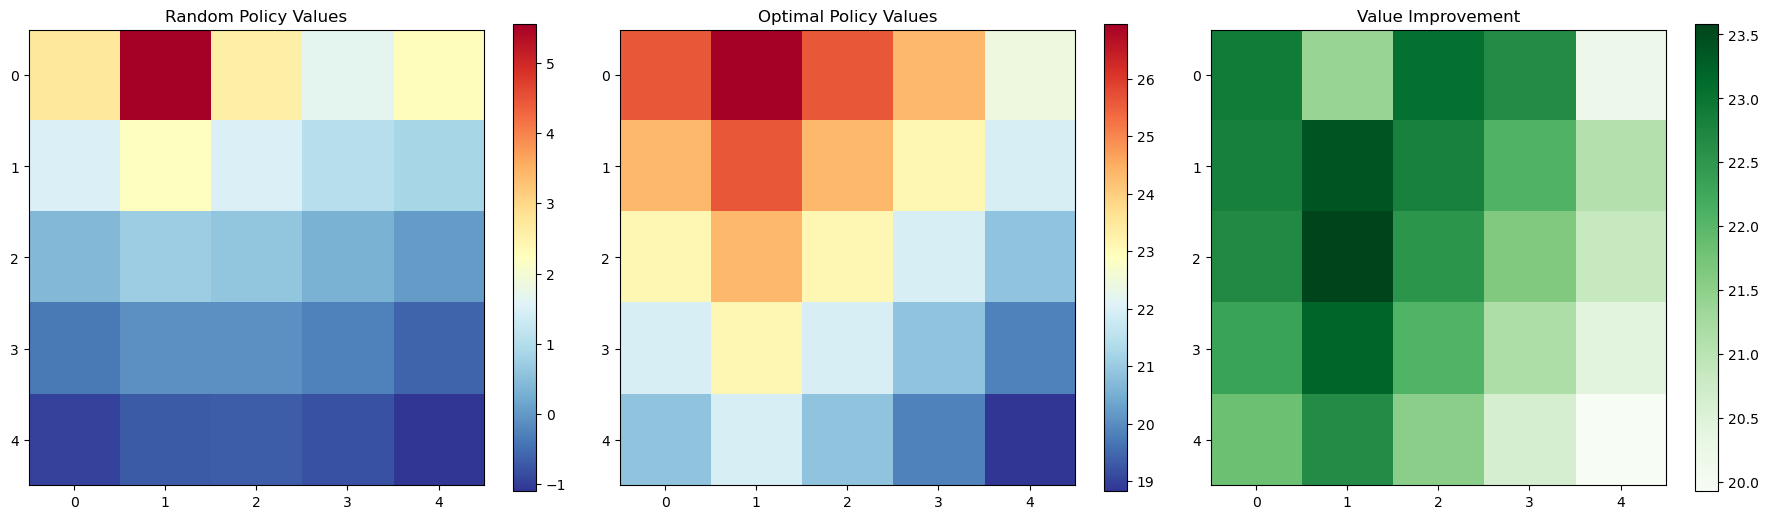

In [ ]:
def compare_with_baseline(optimal_value, baseline_value):
    """Compare optimal policy value with random policy baseline"""

    improvement = optimal_value - baseline_value

    print("=== PERFORMANCE COMPARISON ===")
    print(f"Random Policy (Method 1):")
    print(
        f"  Value range: [{jnp.min(baseline_value):.3f}, {jnp.max(baseline_value):.3f}]"
    )
    print(f"  Mean value: {jnp.mean(baseline_value):.3f}")

    print(f"\nOptimal Policy (Method 2):")
    print(
        f"  Value range: [{jnp.min(optimal_value):.3f}, {jnp.max(optimal_value):.3f}]"
    )
    print(f"  Mean value: {jnp.mean(optimal_value):.3f}")

    print(f"\nImprovement:")
    print(f"  Average improvement: {jnp.mean(improvement):.3f}")
    print(f"  Max improvement: {jnp.max(improvement):.3f}")
    print(f"  Min improvement: {jnp.min(improvement):.3f}")

    # Side-by-side heatmap
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Baseline values
    im1 = ax1.imshow(baseline_value.reshape(5, 5), cmap="RdYlBu_r")
    ax1.set_title("Random Policy Values")
    plt.colorbar(im1, ax=ax1)

    # Optimal values
    im2 = ax2.imshow(optimal_value.reshape(5, 5), cmap="RdYlBu_r")
    ax2.set_title("Optimal Policy Values")
    plt.colorbar(im2, ax=ax2)

    # Improvement
    im3 = ax3.imshow(improvement.reshape(5, 5), cmap="Greens")
    ax3.set_title("Value Improvement")
    plt.colorbar(im3, ax=ax3)

    plt.tight_layout()
    plt.show()


# Compare with your Method 1 results
compare_with_baseline(optimal_value, V_explicit)

In [ ]:
def verify_bellman_optimality_realistic(
    policy, value, R_sa, P_sas, gamma, tolerance=1e-05
):
    """Verify Bellman optimality with realistic numerical tolerance"""

    Q_computed = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, value)
    V_from_Q = jnp.max(Q_computed, axis=1)
    bellman_error = jnp.abs(value - V_from_Q)

    max_error = jnp.max(bellman_error)
    mean_error = jnp.mean(bellman_error)

    print("=== BELLMAN OPTIMALITY VERIFICATION ===")
    print(f"Max Bellman error: {max_error:.2e}")
    print(f"Mean Bellman error: {mean_error:.2e}")
    print(f"Tolerance threshold: {tolerance:.2e}")

    if max_error < tolerance:
        print("✓ Bellman optimality satisfied (within numerical precision)!")
        optimality_status = "Optimal"
    else:
        print("✗ Bellman optimality violation detected")
        optimality_status = "Suboptimal"

    # Relative error analysis
    relative_errors = bellman_error / jnp.abs(value)
    max_rel_error = jnp.max(relative_errors)
    print(f"Max relative error: {max_rel_error:.2e} ({max_rel_error*100:.4f}%)")

    return optimality_status, max_error


status, error = verify_bellman_optimality_realistic(
    optimal_policy, optimal_value, R_sa, P_sas, gamma
)

=== BELLMAN OPTIMALITY VERIFICATION ===
Max Bellman error: 3.81e-06
Mean Bellman error: 7.63e-07
Tolerance threshold: 1.00e-05
✓ Bellman optimality satisfied (within numerical precision)!
Max relative error: 1.83e-07 (0.0000%)


## Method 3: Value Iteration

Direct application of Bellman optimality operator:
$$V_{k+1}(s) = \max_a [R(s,a) + \gamma \sum_{s'} P(s'|s,a) V_k(s')]$$

**Convergence**: $V_k \to V^*$ as $k \to \infty$ by contraction property.


### Value iteration algorithm


In [ ]:
@jit
def value_iteration_step(V, R_sa, P_sas, gamma):
    """Single value iteration update: V_{k+1} = max_a [R + γP V_k]"""
    # Compute Q-values for all state-action pairs
    Q_sa = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)

    # Take max over actions for each state
    V_new = jnp.max(Q_sa, axis=1)

    return V_new, Q_sa


def value_iteration(R_sa, P_sas, gamma, tolerance=1e-8, max_iterations=1000):
    """Full value iteration algorithm"""

    # Initialize value function (can start with zeros)
    V = jnp.zeros(N_STATES)

    value_history = [V]
    convergence_errors = []

    for iteration in range(max_iterations):
        V_new, Q = value_iteration_step(V, R_sa, P_sas, gamma)

        # Check convergence
        max_change = jnp.max(jnp.abs(V_new - V))
        convergence_errors.append(max_change)

        if max_change < tolerance:
            print(f"Value iteration converged after {iteration + 1} iterations")
            print(f"Final max change: {max_change:.2e}")
            break

        V = V_new
        value_history.append(V)

    # Extract final policy (greedy w.r.t. final value function)
    final_policy = extract_greedy_policy(V, R_sa, P_sas, gamma)

    return V, final_policy, value_history, convergence_errors


@jit
def extract_greedy_policy(V, R_sa, P_sas, gamma):
    """Extract greedy policy from value function"""
    Q_sa = R_sa + gamma * jnp.einsum("sab,b->sa", P_sas, V)
    greedy_actions = jnp.argmax(Q_sa, axis=1)

    # Convert to policy matrix
    policy = jnp.zeros((N_STATES, N_ACTIONS))
    policy = policy.at[jnp.arange(N_STATES), greedy_actions].set(1.0)

    return policy

### Execute and Compare


In [ ]:
# Run value iteration
V_value_iter, policy_value_iter, vi_history, vi_errors = value_iteration(
    R_sa, P_sas, gamma
)

print("=== VALUE ITERATION RESULTS ===")
print(f"Final value range: [{jnp.min(V_value_iter):.3f}, {jnp.max(V_value_iter):.3f}]")
print(f"Mean value: {jnp.mean(V_value_iter):.3f}")

Value iteration converged after 285 iterations
Final max change: 0.00e+00
=== VALUE ITERATION RESULTS ===
Final value range: [18.824, 26.955]
Mean value: 22.704


### Cross-Method Validation


In [21]:
def compare_all_methods(V_explicit, V_policy_iter, V_value_iter, policy_pi, policy_vi):
    """Compare all three methods for consistency"""

    print("=== CROSS-METHOD VALIDATION ===")

    # Compare value functions
    pi_vi_diff = jnp.max(jnp.abs(V_policy_iter - V_value_iter))
    print(f"Policy Iteration vs Value Iteration:")
    print(f"  Max value difference: {pi_vi_diff:.2e}")

    # Compare policies (should be identical)
    policy_pi_actions = jnp.argmax(policy_pi, axis=1)
    policy_vi_actions = jnp.argmax(policy_vi, axis=1)

    policy_agreement = jnp.sum(policy_pi_actions == policy_vi_actions)
    print(f"  Policy agreement: {policy_agreement}/{N_STATES} states")

    if policy_agreement == N_STATES and pi_vi_diff < 1e-6:
        print("✓ All methods converged to same solution!")
    else:
        print("✗ Methods disagree - check implementations")

    # Performance vs baseline
    improvement_pi = jnp.mean(V_policy_iter) - jnp.mean(V_explicit)
    improvement_vi = jnp.mean(V_value_iter) - jnp.mean(V_explicit)

    print(f"\nPerformance vs Random Policy:")
    print(f"  Policy Iteration improvement: {improvement_pi:.3f}")
    print(f"  Value Iteration improvement: {improvement_vi:.3f}")


compare_all_methods(
    V_explicit, optimal_value, V_value_iter, optimal_policy, policy_value_iter
)

=== CROSS-METHOD VALIDATION ===
Policy Iteration vs Value Iteration:
  Max value difference: 1.14e-05
  Policy agreement: 21/25 states
✗ Methods disagree - check implementations

Performance vs Random Policy:
  Policy Iteration improvement: 21.970
  Value Iteration improvement: 21.970


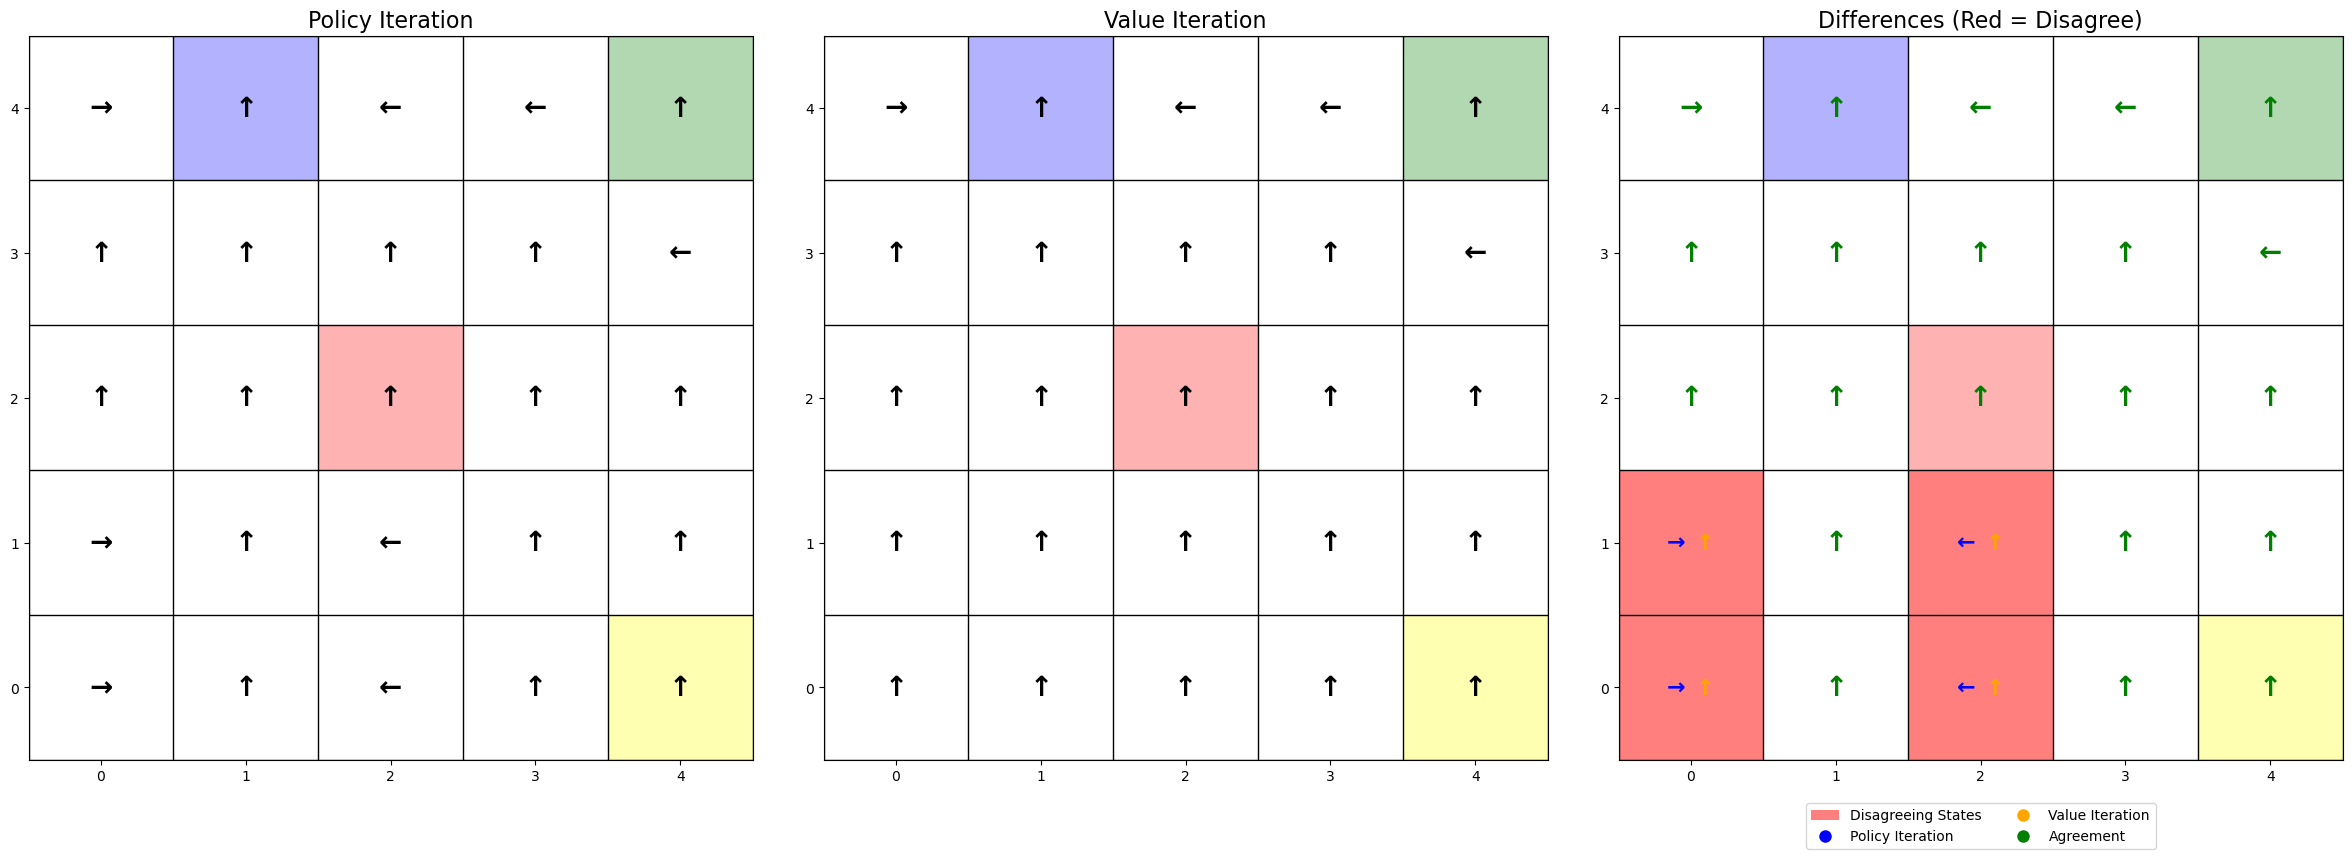

Policy Agreement: 21/25 states
Disagreements: 4 states (due to tied optimal actions)


In [ ]:
def visualize_policy_comparison(policy_pi, policy_vi, ties=None):
    """Compare policies side-by-side, highlighting differences"""

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Extract actions
    actions_pi = jnp.argmax(policy_pi, axis=1)
    actions_vi = jnp.argmax(policy_vi, axis=1)
    action_grid_pi = actions_pi.reshape((GRID_SIZE, GRID_SIZE))
    action_grid_vi = actions_vi.reshape((GRID_SIZE, GRID_SIZE))

    arrow_map = {0: "↑", 1: "↓", 2: "←", 3: "→"}
    special_colors = {
        (0, 1): "blue",  # Blue square
        (0, 4): "green",  # Green square
        (2, 2): "red",  # Red square
        (4, 4): "yellow",  # Yellow square
    }

    # Helper function to draw grid and special states
    def setup_grid(ax, title):
        for i in range(GRID_SIZE + 1):
            ax.axhline(i - 0.5, color="black", linewidth=1)
            ax.axvline(i - 0.5, color="black", linewidth=1)

        for (row, col), color in special_colors.items():
            rect = plt.Rectangle(
                (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor=color, alpha=0.3
            )
            ax.add_patch(rect)

        ax.set_xlim(-0.5, GRID_SIZE - 0.5)
        ax.set_ylim(-0.5, GRID_SIZE - 0.5)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=16)
        ax.set_xticks(range(GRID_SIZE))
        ax.set_yticks(range(GRID_SIZE))

    # Policy Iteration
    setup_grid(ax1, "Policy Iteration")
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            action = action_grid_pi[row, col]
            arrow = arrow_map[int(action)]
            ax1.text(
                col,
                GRID_SIZE - row - 1,
                arrow,
                ha="center",
                va="center",
                fontsize=20,
                fontweight="bold",
            )

    # Value Iteration
    setup_grid(ax2, "Value Iteration")
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            action = action_grid_vi[row, col]
            arrow = arrow_map[int(action)]
            ax2.text(
                col,
                GRID_SIZE - row - 1,
                arrow,
                ha="center",
                va="center",
                fontsize=20,
                fontweight="bold",
            )

    # Differences highlighted
    setup_grid(ax3, "Differences (Red = Disagree)")
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            state_idx = row * GRID_SIZE + col
            pi_action = action_grid_pi[row, col]
            vi_action = action_grid_vi[row, col]

            if pi_action != vi_action:
                # Highlight disagreeing states in red
                rect = plt.Rectangle(
                    (col - 0.5, GRID_SIZE - row - 1.5), 1, 1, facecolor="red", alpha=0.5
                )
                ax3.add_patch(rect)

                # Show both arrows with different colors
                ax3.text(
                    col - 0.1,
                    GRID_SIZE - row - 1,
                    arrow_map[int(pi_action)],
                    ha="center",
                    va="center",
                    fontsize=16,
                    fontweight="bold",
                    color="blue",
                    label="PI" if row == 0 and col == 0 else "",
                )
                ax3.text(
                    col + 0.1,
                    GRID_SIZE - row - 1,
                    arrow_map[int(vi_action)],
                    ha="center",
                    va="center",
                    fontsize=16,
                    fontweight="bold",
                    color="orange",
                    label="VI" if row == 0 and col == 0 else "",
                )
            else:
                # Same action - show in green
                arrow = arrow_map[int(pi_action)]
                ax3.text(
                    col,
                    GRID_SIZE - row - 1,
                    arrow,
                    ha="center",
                    va="center",
                    fontsize=20,
                    fontweight="bold",
                    color="green",
                )

    # Add legend to difference plot
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="red", alpha=0.5, label="Disagreeing States"),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="blue",
            markersize=10,
            label="Policy Iteration",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="orange",
            markersize=10,
            label="Value Iteration",
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="green",
            markersize=10,
            label="Agreement",
        ),
    ]
    ax3.legend(
        handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2
    )

    plt.tight_layout()
    plt.show()

    # Print summary
    disagreements = jnp.sum(actions_pi != actions_vi)
    print(f"Policy Agreement: {N_STATES - disagreements}/{N_STATES} states")
    print(f"Disagreements: {disagreements} states (due to tied optimal actions)")


# Create the comprehensive comparison
visualize_policy_comparison(optimal_policy, policy_value_iter)

### Convergence Rate Analysis


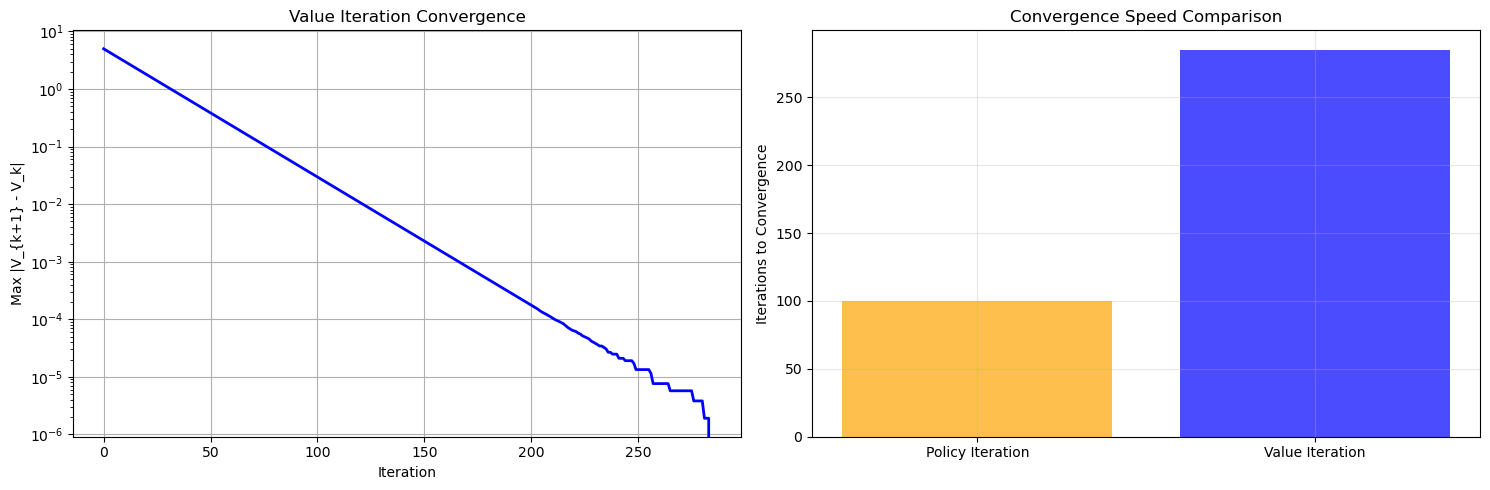

Policy Iteration: 100 iterations
Value Iteration: 285 iterations
→ Policy Iteration converged faster


In [ ]:
def analyze_convergence_rates(pi_history, vi_errors, pi_values, vi_history):
    """Compare convergence characteristics"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Value iteration convergence
    ax1.semilogy(vi_errors, "b-", label="Value Iteration", linewidth=2)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Max |V_{k+1} - V_k|")
    ax1.set_title("Value Iteration Convergence")
    ax1.grid(True)

    # Compare total iterations needed
    vi_iterations = len(vi_errors)
    pi_iterations = len(pi_values)

    ax2.bar(
        ["Policy Iteration", "Value Iteration"],
        [pi_iterations, vi_iterations],
        color=["orange", "blue"],
        alpha=0.7,
    )
    ax2.set_ylabel("Iterations to Convergence")
    ax2.set_title("Convergence Speed Comparison")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Policy Iteration: {pi_iterations} iterations")
    print(f"Value Iteration: {vi_iterations} iterations")

    if pi_iterations < vi_iterations:
        print("→ Policy Iteration converged faster")
    else:
        print("→ Value Iteration converged faster")


analyze_convergence_rates(policy_history, vi_errors, value_history, vi_history)